In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from hpa_src.models.loss import CrossEntropyLossOneHot, FocalLoss
from torch.nn import BCELoss, BCEWithLogitsLoss
import torch

In [48]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# generate targets, assume every sample has two labels
np.random.seed(110)
targets = np.random.randint(0, 28, (100,2))

In [5]:
# Expand to 28 dimension
onehot_targets = np.zeros((100, 28))

In [6]:
onehot_targets[np.arange(100), targets[:,1][np.newaxis]] = 1
onehot_targets[np.arange(100), targets[:,0][np.newaxis]] = 1

In [7]:
# simulate predictions

In [8]:
np.random.seed(110)
predictions = np.random.normal(0, 1, (100,28))

## Class weights

In [9]:
import pandas as pd
DATADIR = '/s/project/junTemp/HPAIC/'
image_df = pd.read_csv(DATADIR + "data/png/train.csv")
image_df['target_list'] = image_df['Target'].map(lambda x: [int(a) for a in x.split(' ')])
import itertools
all_labels = np.array(list(itertools.chain(*image_df.target_list.values)))

In [10]:
class_n = np.unique(all_labels, return_counts=True)[1]

In [11]:
class_n

array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
          45,    28,  1093,   688,   537,  1066,    21,   530,   210,
         902,  1482,   172,  3777,   802,  2965,   322,  8228,   328,
          11])

In [12]:
alpha = class_n / sum(class_n)

## Keras

In [13]:
import keras.backend as K
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [14]:
pred_prob = K.eval(K.sigmoid(predictions))

In [15]:
K.eval(binary_crossentropy(K.variable(onehot_targets), K.variable(pred_prob))).mean()

0.7970609

## Pytorch

In [16]:
predictions = torch.from_numpy(predictions)

In [17]:
onehot_targets = torch.from_numpy(onehot_targets)

In [18]:
bcelogit = BCEWithLogitsLoss()
bce = BCELoss()
ce = CrossEntropyLossOneHot()

/opt/modules/i12g/anaconda/3-5.0.1/envs/hpaic/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [19]:
bcelogit(predictions, onehot_targets, )

tensor(0.7971, dtype=torch.float64)

In [20]:
torch.mean(ce(predictions, onehot_targets))

tensor(3.7854, dtype=torch.float64)

In [77]:
import torch.nn as nn
import torch
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, 
                 alpha=1, 
                 gamma=2, 
                 logits=False, 
                 reduction='elementwise_mean'):
        
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none') # -log(p_t), p_t: predicted target prob
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * torch.pow((1-pt), self.gamma) * BCE_loss

        if self.reduction == 'none':
            return F_loss
        elif self.reduction == 'elementwise_mean':
            return torch.mean(F_loss)
        else:
            return F_loss.sum()

In [22]:
focal = FocalLoss(gamma=0, logits=True, alpha=alpha)

In [23]:
focal(predictions, onehot_targets)

tensor(0.0293, dtype=torch.float64)

## Plot loss

In [81]:
focal = FocalLoss(gamma=2, logits=False, reduction='none')

In [83]:
bce = BCELoss(reduction='none')

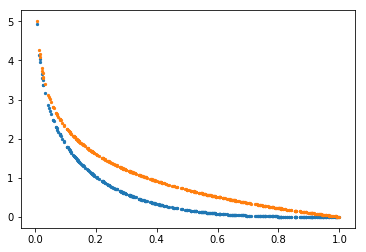

In [84]:
pred = torch.rand((16, 28))

plt.scatter(pred.flatten().numpy(), focal(pred, torch.ones((16, 28))).flatten().numpy(), s= 5)
plt.scatter(pred.flatten().numpy(), bce(pred, torch.ones((16, 28))).flatten().numpy(), s= 5)
plt.show()

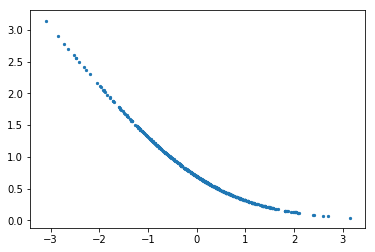

In [73]:
plt.scatter(pred.flatten().numpy(), bce(pred, torch.ones((16, 28))).flatten().numpy(), s= 5)
plt.show()

In [65]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss#.sum(dim=1).mean()

In [66]:
focal2 = FocalLoss(gamma=2)

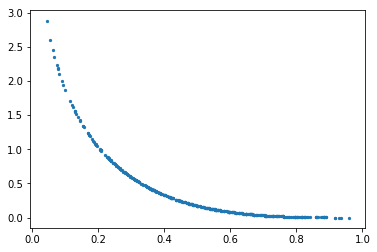

In [69]:
pred = torch.randn((16, 28))

plt.scatter(torch.sigmoid(pred).flatten().numpy(), focal2(pred, torch.ones((16, 28))).flatten().numpy(), s= 5)
plt.show()

In [ ]:
def binary_cross_entropy_with_logits(input, target, weight=None, size_average=None,
                                     reduce=None, reduction='elementwise_mean', pos_weight=None):
    r"""Function that measures Binary Cross Entropy between target and output
    logits.

    See :class:`~torch.nn.BCEWithLogitsLoss` for details.

    Args:
        input: Tensor of arbitrary shape
        target: Tensor of the same shape as input
        weight (Tensor, optional): a manual rescaling weight
            if provided it's repeated to match input tensor shape
        size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
            the losses are averaged over each loss element in the batch. Note that for
            some losses, there multiple elements per sample. If the field :attr:`size_average`
            is set to ``False``, the losses are instead summed for each minibatch. Ignored
            when reduce is ``False``. Default: ``True``
        reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, the
            losses are averaged or summed over observations for each minibatch depending
            on :attr:`size_average`. When :attr:`reduce` is ``False``, returns a loss per
            batch element instead and ignores :attr:`size_average`. Default: ``True``
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'elementwise_mean' | 'sum'. 'none': no reduction will be applied,
            'elementwise_mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`. Default: 'elementwise_mean'
        pos_weight (Tensor, optional): a weight of positive examples.
                Must be a vector with length equal to the number of classes.

    Examples::

         >>> input = torch.randn(3, requires_grad=True)
         >>> target = torch.empty(3).random_(2)
         >>> loss = F.binary_cross_entropy_with_logits(input, target)
         >>> loss.backward()
    """
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)
    if not (target.size() == input.size()):
        raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

    max_val = (-input).clamp(min=0)

    if pos_weight is None:
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()
    else:
        log_weight = 1 + (pos_weight - 1) * target
        loss = input - input * target + log_weight * (max_val + ((-max_val).exp() + (-input - max_val).exp()).log())

    if weight is not None:
        loss = loss * weight

    if reduction == 'none':
        return loss
    elif reduction == 'elementwise_mean':
        return loss.mean()
    else:
        return loss.sum()